In [1]:
%matplotlib inline
import torch
import random
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from matplotlib import pyplot
import seaborn as sns
import os

#Plotting 
from pandas.plotting import scatter_matrix

#Libraries for Statistical Models
import statsmodels.api as sm

#logging
from util.logconf import logging
log = logging.getLogger(__name__)
# log.setLevel(logging.WARN)
log.setLevel(logging.INFO)
# log.setLevel(logging.DEBUG)


#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None
pd.options.display.expand_frame_repr = False
pd.options.display.float_format = '{:.3f}'.format

torch.seed = 42
random.seed(42)
np.random.seed(42)

%run 'nb_utils.ipynb'
task_name = get_filename_of_ipynb()
print(task_name)
data_dir = f'{os.getcwd()}/data/'
log_dir_base = f'{os.getcwd()}/runs/{task_name}'
log_dir = log_dir_base
print(f'{data_dir}\n{log_dir}')

return_period = 5


StockPCTLabelPredictLSTM
/mnt/AIWorkSpace/work/fin-ml/data/
/mnt/AIWorkSpace/work/fin-ml/runs/StockPCTLabelPredictLSTM


In [ ]:
# hyperparameters turning
from ray import tune, train, ray
from ray.tune.schedulers import ASHAScheduler

ray.init(log_to_driver=False)

In [8]:
from datetime import datetime
import yfinance as yfin

# Loading the data
stk_tickers = [
    "AAPL",
    "MSFT",
    "AMZN",
    "NVDA",
    "GOOGL",
    "TSLA",
    "META",
    "GOOG",
    "ADBE",
    "NFLX",
    "CSCO",
    "INTC",
    "INTU",
    "CMCSA",
    "TXN",
    "AMAT",
    "ADSK",
    "AMD",
    "QCOM",
    "MU",
]

start = datetime(2014, 1, 1)
end = datetime(2023, 12, 31)

ticks_data = []
for stk_symbol in stk_tickers:
    stk_file = f"{data_dir}{stk_symbol}.csv"
    bLoad = False
    if os.path.isfile(stk_file):
        try:
            _stk_data = pd.read_csv(stk_file).set_index("Date")
            bLoad = True
            print(f"read {stk_file} completely!")
        except:
            None
    if bLoad == False:
        # _stk_data = web.get_data_yahoo(stk_tickers, start, end)
        _stk_data = yfin.download([stk_symbol], start, end).dropna()
        _stk_data.to_csv(stk_file)
        print(f"download {stk_symbol} from yfin and write to {stk_file} completely!")
    ticks_data.append(_stk_data)

print(ticks_data)

read /mnt/AIWorkSpace/work/fin-ml/data/AAPL.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/MSFT.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/AMZN.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/NVDA.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/GOOGL.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/TSLA.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/META.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/GOOG.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/ADBE.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/NFLX.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/CSCO.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/INTC.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/INTU.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/CMCSA.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/TXN.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/AMAT.csv completely!
read /mnt/AIWorkSpace/work/fin-ml/data/

In [3]:
import torch

device_name = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device = torch.device(device_name)
seq_len = 5
validation_size = 0.2
epoch_num = 100
batch_size = 32
num_workers = 1
pin_memory = False  # True
shuffle = False  # True
print(f"device_name:{device}")

device_name:cuda


In [30]:
stk_data = ticks_data[0].copy()
print(stk_data)
xx = pd.DataFrame(index=stk_data.index)
xx["max_5"] = stk_data["Adj Close"].rolling(return_period).max().shift(-return_period)
print(xx)
xx["max_pct_5"] = (xx["max_5"] - stk_data["Adj Close"]) / stk_data["Adj Close"]
# xx["test"] = stk_data["Adj Close"] * (1 + xx["max_pct_5"])
print(xx.head(10))

a = stk_data["Adj Close"].rolling(return_period).max().shift(-return_period)
b = (a - stk_data["Adj Close"]) / stk_data["Adj Close"]
print(b)

              Open    High     Low   Close  Adj Close     Volume
Date                                                            
2014-01-02  19.846  19.894  19.715  19.755     17.319  234684800
2014-01-03  19.745  19.775  19.301  19.321     16.938  392467600
2014-01-06  19.195  19.529  19.057  19.426     17.031  412610800
2014-01-07  19.440  19.499  19.211  19.287     16.909  317209200
2014-01-08  19.243  19.484  19.239  19.409     17.016  258529600
...            ...     ...     ...     ...        ...        ...
2023-12-22 195.180 195.410 192.970 193.600    193.600   37122800
2023-12-26 193.610 193.890 192.830 193.050    193.050   28919300
2023-12-27 192.490 193.500 191.090 193.150    193.150   48087700
2023-12-28 194.140 194.660 193.170 193.580    193.580   34049900
2023-12-29 193.900 194.400 191.730 192.530    192.530   42628800

[2516 rows x 6 columns]
            max_5
Date             
2014-01-02 17.031
2014-01-03 17.031
2014-01-06 17.016
2014-01-07 17.108
2014-01-08 17.451
... 

In [55]:
# number of classes = 3
# 0: PCT <= -0.05
# 1: 0.05 < PCT < -0.05
# 2: PCT >= -0.05
num_classes = 3
pct_threshold = 0.05
classificationThreshold = 0.5


def gen_pct_label(stk_data, _return_period):
    max_price_period = (
        stk_data["Adj Close"].rolling(_return_period).max().shift(-_return_period)
    )
    max_pct_period = (max_price_period - stk_data["Adj Close"]) / stk_data["Adj Close"]
    pct_label = max_pct_period.apply(
        lambda x: 2 if x >= pct_threshold else 0 if x <= -pct_threshold else 1
    ).astype("int8")
    pct_label.name = "label"
    return pct_label

In [48]:
def gen_buy_sell_signal(stk_data):
    import pandas_ta as ta

    sma = pd.concat(
        [
            stk_data.ta.sma(close="Adj Close", length=10),
            stk_data.ta.sma(close="Adj Close", length=60),
        ],
        axis=1,
    ).dropna()
    buy_signal = sma["SMA_10"] > sma["SMA_60"]

    buy_sell_signal = stk_data[[]].copy()
    buy_sell_signal["Signal"] = (buy_signal).astype("int")

    return buy_sell_signal


def gen_analysis_data(stk_data, _return_period):
    import pandas_ta as ta

    data = pd.concat(
        [
            stk_data.ta.adosc(),
            stk_data.ta.kvo(),
            stk_data.ta.rsi(close="Adj Close", length=10) / 100,
            stk_data.ta.rsi(close="Adj Close", length=30) / 100,
            stk_data.ta.rsi(close="Adj Close", length=200) / 100,
            stk_data.ta.stoch(k=10) / 100,
            stk_data.ta.stoch(k=30) / 100,
            stk_data.ta.stoch(k=200) / 100,
            gen_buy_sell_signal(stk_data),
        ],
        axis=1,
    )

    data = pd.concat(
        [data.astype("float32"), gen_pct_label(stk_data, _return_period)],
        axis=1,
    ).dropna()
    return data

   AAPL  MSFT  AMZN  NVDA  GOOGL  TSLA  META  GOOG  ADBE  NFLX  CSCO  INTC  INTU  CMCSA   TXN  AMAT  ADSK   AMD  QCOM    MU
0     6     7    14    32      9    55    17     8    13    26     7    17    10      8     8    25    17    50    20    41
1  2022  2092  1929  1574   2069  1475  1915  2058  1957  1735  2141  1975  1981   2162  2085  1779  1873  1374  1933  1590
2   285   214   370   707    235   783   381   247   343   552   165   321   322    143   220   509   423   889   360   682
class 0: 0.008%,   390
class 1: 0.815%, 37719
class 2: 0.176%,  8151


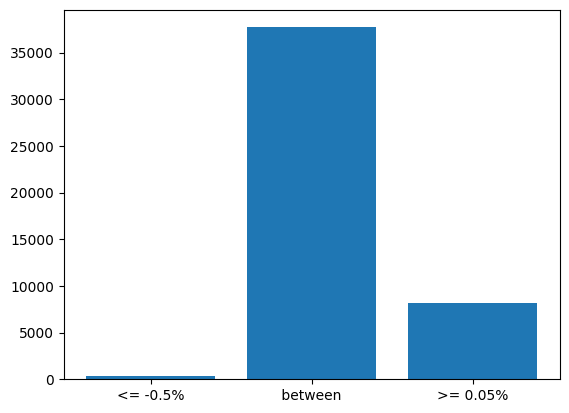

In [99]:
classes_df = pd.DataFrame()
for i, stk_data in enumerate(ticks_data):
    label_stat = gen_analysis_data(stk_data, return_period).groupby("label").size()
    label_stat.name = stk_tickers[i]
    classes_df = pd.concat([classes_df, label_stat], axis=1)
print(classes_df)
classes_count = [classes_df.iloc[i].sum() for i in range(num_classes)]
total_recs = sum(classes_count)
for i, v in enumerate(classes_count):
    print(f"class {i}: {v/total_recs:.3f}%, {v:>5d}")
pyplot.bar(["<= -0.5%", " between ", ">= 0.05%"], classes_count)
pyplot.show()

In [100]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class LSTMDataSet(Dataset):
    def __init__(self, ticks_data_X, ticks_data_Y, seq_len):
        self.ticks_data_X = ticks_data_X
        self.ticks_data_Y = ticks_data_Y
        self.seq_len = seq_len
        len_array = [len(d) - self.seq_len + 1 for d in ticks_data_X]
        self.idx_boundary = [len_array[0]]

        for i in range(1, len(len_array)):
            self.idx_boundary.append(len_array[i] + self.idx_boundary[i - 1])

    def __len__(self):
        # print(f"len of dataset:{self.idx_boundary[-1]}")
        return self.idx_boundary[-1]  # len(self.X) - self.seq_len + 1

    def __getitem__(self, idx):
        for ticks_data_idx in range(len(self.ticks_data_X)):
            if self.idx_boundary[ticks_data_idx] > idx:
                break
        offset = (
            idx if ticks_data_idx == 0 else idx - self.idx_boundary[ticks_data_idx - 1]
        )
        # print(f"{ticks_data_idx}, {offset}")
        return (
            np.array(self.ticks_data_X[ticks_data_idx][offset : offset + self.seq_len]),
            int(self.ticks_data_Y[ticks_data_idx].iloc[offset + self.seq_len - 1, :]),
        )

In [101]:
import random
import math
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn_pandas import DataFrameMapper


def prepare_dataloader(_return_period, _seq_len):
    ticks_dataset = [gen_analysis_data(d, _return_period) for d in ticks_data]
    ticks_X_train_data = []
    ticks_Y_train_data = []
    ticks_X_test_data = []
    ticks_Y_test_data = []
    ticks_X_dfm = []
    for dataset in ticks_dataset:
        test_size = int(dataset.shape[0] * validation_size)
        # random.seed(42)
        test_data_idx = random.sample(range(0, dataset.shape[0]), test_size)
        mask = np.full(len(dataset), False)
        mask[test_data_idx] = True
        train_data = dataset[~mask]
        test_data = dataset[mask]

        X_train_data = train_data.iloc[:, :-1]
        Y_train_data = train_data.iloc[:, -1:]

        X_test_data = test_data.iloc[:, :-1]
        Y_test_data = test_data.iloc[:, -1:]

        features = [
            ([column], StandardScaler()) for column in X_train_data.columns[:3].values
        ]
        features.extend(
            [([column], None) for column in X_train_data.columns[3:].values]
        )
        # print(features)
        X_dfm = DataFrameMapper(features, input_df=True, df_out=True)
        X_train_data = X_dfm.fit_transform(X_train_data)
        X_test_data = X_dfm.transform(X_test_data)

        ticks_X_dfm.append(X_dfm)
        ticks_X_train_data.append(X_train_data)
        ticks_Y_train_data.append(Y_train_data)
        ticks_X_test_data.append(X_test_data)
        ticks_Y_test_data.append(Y_test_data)

    train_loader = DataLoader(
        LSTMDataSet(ticks_X_train_data, ticks_Y_train_data, _seq_len),
        batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory,
        pin_memory_device=device_name,
    )
    test_loader = DataLoader(
        LSTMDataSet(ticks_X_test_data, ticks_Y_test_data, _seq_len),
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        pin_memory_device=device_name,
    )

    return train_loader, test_loader, ticks_X_train_data[0].shape[1]

In [102]:
from torch import nn


class StockPCTLabelPredictLSTM(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        num_layers,
        num_fc_layers,
        activation_type,
    ):
        super().__init__()
        self.setup_model(
            input_size,
            hidden_size,
            num_layers,
            num_fc_layers,
            activation_type,
        )

    def __init__(self, input_size, config):
        self.setup_model(
            input_size=input_size,
            hidden_size=config["hidden_size"],
            num_layers=config["num_layers"],
            num_fc_layers=config["num_fc_layers"],
            activation_type=config["activation_type"],
        )

    def setup_model(
        self,
        input_size,
        hidden_size,
        num_layers,
        num_fc_layers,
        activation_type,
    ):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        """
            input_size    : The number of expected features in the input x
            hidden_size   : The number of features in the hidden state h
            num_layers    : Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1
            bias          : If False, then the layer does not use bias weights b_ih and b_hh. Default: True
            batch_first   : If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states. See the Inputs/Outputs sections below for details. Default: False
            dropout       : If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to dropout. Default: 0
            bidirectional : If True, becomes a bidirectional LSTM. Default: False
            proj_size     : If > 0, will use LSTM with projections of corresponding size. Default: 0
        """
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        layers = []
        in_features = self.hidden_size
        for i in range(1, num_fc_layers):
            out_features = int(in_features / 2)
            if out_features <= num_classes:
                break
            layers.append(nn.Linear(in_features, out_features))
            layers.append(
                nn.ReLU() if activation_type == 1 else nn.Sigmoid()
            ) if activation_type == 2 else nn.Tanh()
            in_features = out_features

        layers.append(nn.Linear(in_features, num_classes))
        self.fc = nn.Sequential(*layers)
        self.fc.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            initrange = 0.5
            nn.init.uniform_(m.weight, -initrange, initrange)
            nn.init.zeros_(m.bias)
            # print(f"{m.in_features},{m.out_features}")

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        out, (h_out, _) = self.rnn(x, (h_0, c_0))

        fc_input = h_out[-1].view(-1, self.hidden_size)
        return self.fc(fc_input)


def save_model(model, hyper_parameters, file_path, epoch_num=None):
    state = {
        "epoch_num": epoch_num,
        "time": str(datetime.now),
        "model_state": model.state_dict(),
        "input_size": model.input_size,
        "hyper_parameters": hyper_parameters,
    }
    # print(f"save model:{file_path}")
    torch.save(state, file_path)


def load_model(file_path):
    data_dict = torch.load(file_path)
    hyper_parameters = data_dict["hyper_parameters"]
    model = StockPCTLabelPredictLSTM(
        input_size=data_dict["input_size"],
        hidden_size=int(hyper_parameters["hidden_size"]),
        num_layers=int(hyper_parameters["num_layers"]),
        num_fc_layers=int(hyper_parameters["num_fc_layers"]),
        activation_type=int(hyper_parameters["activation_type"]),
    )
    model.load_state_dict(data_dict["model_state"])
    return model, hyper_parameters

In [ ]:
import math
from sklearn.metrics import mean_squared_error
import torch


def gen_f1_score(ground_truth, predict_results):
    score_metric = []
    for target_label in range(predict_results.shape[1]):
        posLabel_mask = ground_truth == target_label
        pos_count = posLabel_mask.sum()
        negLabel_mask = ground_truth != target_label
        neg_count = negLabel_mask.sum()

        predict_value, predict_label = torch.max(predict_results, dim=1)
        posPred_mask = predict_label == target_label
        posPred_threshold_mask = predict_value > classificationThreshold
        # TP, truePos_count
        TP = pos_correct = int(
            (posLabel_mask & posPred_mask & posPred_threshold_mask).sum()
        )

        negPred_mask = predict_label != target_label
        # TN, trueNeg_count
        TN = neg_correct = int((negLabel_mask & negPred_mask).sum())

        # FP, falsePos_count
        FP = neg_count - neg_correct
        # FN, falseNeg_count
        FN = pos_count - pos_correct

        # precision = TP / (TP + FP)
        precision = TP / (TP + FP)
        # recall = TP / (TP + FN)
        recall = TP / (TP + FN)
        # F1 = 2 * precision * recall / (precision + recall)
        f1 = (2 * precision * recall) / (precision + recall)
        score_metric.append({"precision": precision, "recall": recall, "F1": f1})

    return score_metric

In [103]:
import torch.nn as nn

METRICS_LABEL_NDX = 0  # ground_truth
METRICS_PBTY_NDX = 1  # Probability of predicition
METRICS_PRED_NDX = 2  # class(label) of predicition
METRICS_LOSS_NDX = 3
METRICS_SIZE = 4
softmax = nn.Softmax(dim=1)
trn_writer = None
val_writer = None

In [105]:
from torch.utils.tensorboard import SummaryWriter

writers = {}


def initTensorboardWriters():
    if trn_writer is None:
        writers["trn"] = SummaryWriter(log_dir=log_dir + "-trn_cls")
        writers["val"] = SummaryWriter(log_dir=log_dir + "-val_cls")

In [20]:
from collections import namedtuple

totalTrainingSamples_count = 0


def logMetrics(
    self,
    epoch_ndx,
    mode_str,
    metrics_t,
    classificationThreshold=0.5,
):
    initTensorboardWriters()
    log.info(
        "E{} {}".format(
            epoch_ndx,
            type(self).__name__,
        )
    )
    F1_rec = namedtuple(
        "f1_rec",
        "pos_correct neg_correct pos_count neg_count pos_loss neg_loss precision recall F1",
    )
    F1_metrics = []
    for target_class in range(num_classes):
        posLabel_mask = metrics_t[METRICS_LABEL_NDX] == target_class
        pos_count = posLabel_mask.sum()
        negLabel_mask = metrics_t[METRICS_LABEL_NDX] != target_class
        neg_count = negLabel_mask.sum()

        posPred_mask = metrics_t[METRICS_PRED_NDX] == target_class
        posPred_threshold_mask = metrics_t[METRICS_PBTY_NDX] > classificationThreshold
        # TP, truePos_count
        TP = pos_correct = int(
            (posLabel_mask & posPred_mask & posPred_threshold_mask).sum()
        )

        negPred_mask = metrics_t[METRICS_PRED_NDX] != target_class
        # TN, trueNeg_count
        TN = neg_correct = int((negLabel_mask & negPred_mask).sum())

        # FP, falsePos_count
        FP = neg_count - neg_correct
        # FN, falseNeg_count
        FN = pos_count - pos_correct

        # precision = TP / (TP + FP)
        precision = 0.0 if (TP + FP) == 0 else TP / np.float32(TP + FP)
        # recall = TP / (TP + FN)
        recall = 0.0 if (TP + FN) == 0 else TP / np.float32(TP + FN)
        # F1 = 2 * precision * recall / (precision + recall)
        F1 = (
            0.0
            if (precision + recall) == 0.0
            else (2 * precision * recall) / np.float32(precision + recall)
        )
        F1_metrics.append(
            F1_rec(
                pos_correct,
                neg_correct,
                pos_count,
                neg_count,
                metrics_t[METRICS_LOSS_NDX, posLabel_mask].mean(),
                metrics_t[METRICS_LOSS_NDX, negLabel_mask].mean(),
                precision,
                recall,
                F1,
            )
        )

    metrics_dict = {}
    metrics_dict["loss/all"] = metrics_t[METRICS_LOSS_NDX].mean()
    log.info(
        ("E{} {:8} {loss/all:.4f} loss").format(
            epoch_ndx,
            mode_str,
            **metrics_dict,
        )
    )

    for target_class, rec in enumerate(F1_metrics):
        metrics_dict[f"{target_class} loss/pos"] = rec.pos_loss
        metrics_dict[f"{target_class} loss/neg"] = rec.neg_loss
        metrics_dict[f"{target_class} correct/all"] = (
            (rec.pos_correct + rec.neg_correct) / metrics_t.shape[1] * 100
        )
        metrics_dict[f"{target_class} correct/neg"] = (
            (rec.neg_correct) / rec.neg_count * 100
        )
        metrics_dict[f"{target_class} correct/pos"] = (
            (rec.pos_correct) / rec.pos_count * 100
        )
        metrics_dict[f"{target_class} pr/precision"] = rec.precision
        metrics_dict[f"{target_class} pr/recall"] = rec.recall
        metrics_dict[f"{target_class} pr/f1_score"] = rec.F1

        log.info(
            (
                '{f"{target_class}" correct/all:-5.1f}% correct, '
                + '{f"{target_class}" pr/precision:.4f} precision, '
                + '{f"{target_class}" pr/recall:.4f} recall, '
                + '{f"{target_class}" pr/f1_score:.4f} f1 score'
            ).format(**metrics_dict)
        )
        log.info(
            (
                'E{} {:8} {f"{target_class}" loss/neg:.4f} loss, '
                + '{f"{target_class}" correct/neg:-5.1f}% correct ({neg_correct:} of {neg_count:})'
            ).format(
                epoch_ndx,
                mode_str + "_neg",
                neg_correct=neg_correct,
                neg_count=neg_count,
                **metrics_dict,
            )
        )
        log.info(
            (
                'E{} {:8} {f"{target_class}" loss/pos:.4f} loss, '
                + '{f"{target_class}" correct/pos:-5.1f}% correct ({pos_correct:} of {pos_count:})'
            ).format(
                epoch_ndx,
                mode_str + "_pos",
                pos_correct=pos_correct,
                pos_count=pos_count,
                **metrics_dict,
            )
        )

    writer = writers[mode_str]
    for key, value in metrics_dict.items():
        writer.add_scalar(key, value, totalTrainingSamples_count)

    writer.add_pr_curve(
        "pr",
        metrics_t[METRICS_LABEL_NDX],
        metrics_t[METRICS_PBTY_NDX],
        metrics_t[METRICS_PRED_NDX],
        totalTrainingSamples_count,
    )

    # bins = [x / 50.0 for x in range(51)]

    # negHist_mask = negLabel_mask & (metrics_t[METRICS_PRED_NDX] > 0.01)
    # posHist_mask = posLabel_mask & (metrics_t[METRICS_PRED_NDX] < 0.99)

    # if negHist_mask.any():
    #     writer.add_histogram(
    #         "is_neg",
    #         metrics_t[METRICS_PRED_NDX, negHist_mask],
    #         self.totalTrainingSamples_count,
    #         bins=bins,
    #     )
    # if posHist_mask.any():
    #     writer.add_histogram(
    #         "is_pos",
    #         metrics_t[METRICS_PRED_NDX, posHist_mask],
    #         self.totalTrainingSamples_count,
    #         bins=bins,
    #     )

IndentationError: expected an indented block (2704229955.py, line 58)

In [ ]:
def eval_dl_method_v0(model, dl, device=device):
    from sklearn.metrics import f1_score

    model.eval()
    y_gt = []
    y_pred = []
    total = 0
    correct = 0
    f1 = 0
    for x, y in dl:
        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        values, predicted = torch.max(outputs, dim=1)
        total += y.shape[0]
        correct += int((predicted == y).sum())
        # f1 += f1_score(y.cpu().detach(), predicted.cpu().detach())

    accuracy = correct / total
    f1 = f1 / len(dl)
    # print(f"Accuracy: {accuracy:.3f}, F1 score:{f1:.3f}")
    return accuracy, f1

In [ ]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

import warnings

warnings.filterwarnings("ignore")
_best_loss = 999.0
_best_accuracy = 0.0


def do_train_v0(
    model,
    optimizer,
    train_dl,
    test_dl,
    id_str,
    config,
    writer=None,
    report_to_Ray=False,
):
    global _best_loss
    global _best_accuracy

    criterion = torch.nn.CrossEntropyLoss()

    model_name = f"{log_dir}/{id_str}.pt"

    total_loss = 0.0
    total_accuracy = 0.0
    # for epoch in tqdm(range(epoch_num)):
    for epoch in range(epoch_num):
        model.train()
        running_loss = 0.0

        total_size = 0
        total_correct_size = 0
        for i, (x, y) in enumerate(train_dl):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            # if torch.isnan(outputs).any():
            #     print(f"NaN: epoch={epoch}, i={i}")
            #     with pd.option_context("display.max_rows", None):
            #         print(x)
            #     break

            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, dim=1)
            total_size += y.shape[0]
            total_correct_size += int((predicted == y).sum())

        with torch.no_grad():
            accuracy, f1 = eval_dl_method(model, test_dl)
            if accuracy > _best_accuracy:
                _best_accuracy = accuracy

            if loss.item() < _best_loss:
                _best_loss = loss.item()
                save_model(model, config, model_name)

        total_loss += running_loss / len(train_dl)
        total_accuracy += accuracy
        if report_to_Ray:
            train.report(
                {
                    "loss": running_loss / len(train_dl),
                    "train_accuracy": total_correct_size / total_size,
                    "mean_accuracy": accuracy,
                }
            )
        if writer != None:
            writer.add_scalars(
                "Training vs. Validation Loss",
                {
                    "loss": running_loss / len(train_dl),
                    "train_accuracy": total_correct_size / total_size,
                    "mean_accuracy": accuracy,
                },
                epoch + 1,
            )
            writer.flush()

    return {
        "Train loss": total_loss / epoch_num,
        "Validation Accuracy": total_accuracy / epoch_num,
    }

In [19]:
def computeBatchLoss(model, loss_fn, x, y, metrics_g, batch_idx):
    x_g = x.to(device)
    y_g = y.to(device)
    outputs = model(x_g)
    loss_g = loss_fn(outputs, y_g)
    probability_g, predition_g = torch.max(softmax(outputs), dim=1)

    start_ndx = batch_idx * batch_size
    end_ndx = start_ndx + y.size(0)

    metrics_g[METRICS_LABEL_NDX, start_ndx:end_ndx] = y_g[:, 1]
    metrics_g[METRICS_PBTY_NDX, start_ndx:end_ndx] = probability_g[:, 1]
    metrics_g[METRICS_PRED_NDX, start_ndx:end_ndx] = predition_g[:, 1]
    metrics_g[METRICS_LOSS_NDX, start_ndx:end_ndx] = loss_g

    return loss_g.mean()

In [10]:
from util import enumerateWithEstimate
import torch


def doTraining(model, optimizer, loss_fn, epoch_ndx, train_dl):
    model.train()
    trnMetrics_g = torch.zeros(
        METRICS_SIZE,
        len(train_dl.dataset),
        device=device,
    )

    batch_iter = enumerateWithEstimate(
        train_dl,
        "E{} Training".format(epoch_ndx),
        start_ndx=train_dl.num_workers,
    )
    for batch_ndx, (x, y) in batch_iter:
        optimizer.zero_grad()

        loss = computeBatchLoss(
            model,
            loss_fn,
            x,
            y,
            trnMetrics_g,
            batch_ndx,
        )

        loss.backward()
        optimizer.step()

    totalTrainingSamples_count += len(train_dl.dataset)
    return trnMetrics_g.to("cpu")

In [11]:
def doValidation(model, loss_fn, epoch_ndx, val_dl):
    from sklearn.metrics import f1_score

    with torch.no_grad():
        model.eval()
        valMetrics_g = torch.zeros(
            METRICS_SIZE,
            len(val_dl.dataset),
            device=device,
        )

        batch_iter = enumerateWithEstimate(
            val_dl,
            "E{} Validation ".format(epoch_ndx),
            start_ndx=val_dl.num_workers,
        )
        for batch_ndx, (x, y) in batch_iter:
            computeBatchLoss(model, loss_fn, x, y, valMetrics_g, batch_ndx)

    return valMetrics_g.to("cpu")

In [11]:
def train_LSTM(config, tensorreport=False):
    _return_period = config["return_period"]
    lr = config["lr"]
    momentum = config["momentum"]
    optim_type = config["optim_type"]
    totalTrainingSamples_count = 0

    id_str = "_".join(str(v) if v < 1 else f"{v:g}" for v in config.values())
    print(id_str)

    if tensorreport:
        writer = SummaryWriter(f"{log_dir}/{id_str}")
    train_loader, test_loader, features_size = prepare_dataloader(_return_period)
    model = StockPCTLabelPredictLSTM(input_size=features_size, config=config)
    model = model.to(device)

    optimizer = (
        torch.optim.Adam(model.parameters(), lr=lr)
        if optim_type == 1
        else torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    )
    loss_fn = torch.nn.CrossEntropyLoss(reduction="none")

    for epoch_ndx in range(epoch_num):
        trnMetrics_t = doTraining(model, optimizer, loss_fn, epoch_ndx, train_loader)
        logMetrics(epoch_ndx, "trn", trnMetrics_t)

        valMetrics_t = doValidation(model, loss_fn, epoch_ndx, test_loader)
        logMetrics(epoch_ndx, "val", valMetrics_t)

In [ ]:
time_str = datetime.now().strftime("%Y-%m-%d_%H.%M.%S")
log_dir = f"{log_dir_base}/{time_str}"
config = {
    "return_period": 5,
    "seq_len": 5,
    "lr": 0.01,
    "momentum": 0.11646759543664197,
    "optim_type": 1,  # Adam
    "num_layers": 4,
    "hidden_size": 64,
    "num_fc_layers": 1,
    "activation_type": 2,  # Sigmoid
}
epoch_num = 20
# os.mkdir(log_dir)
print(log_dir)
train_LSTM(config, tensorreport=True)

In [18]:
search_space = {
    "return_period": tune.grid_search([5]),  # [2,3,5,10]
    "seq_len": tune.grid_search([5]),  # 10]),
    "lr": tune.grid_search([0.01]),  # [0.001, 0.01, 0.1]
    "momentum": tune.uniform(0.1, 0.9),
    "optim_type": tune.grid_search([1]),  # 1: Adam, 2: SGD
    "num_layers": tune.grid_search([4, 16]),  # [1, 2, 4, 8]
    "hidden_size": tune.grid_search([32, 64, 128, 256]),  # [8, 16, 32, 64, 128]
    "num_fc_layers": tune.grid_search([1, 2]),  # 1, 2, 3]),
    "activation_type": tune.grid_search(
        [1, 2, 3]
    ),  # 1: ReLU(),  2: Sigmoid(),  3: Tanh()
}

turning_parameters = []
total_configs = 1
for k, v in search_space.items():
    if (
        type(v).__name__ == "dict"
        and list(v.keys())[0] == "grid_search"
        and len(list(v.values())[0]) > 1
    ):
        turning_parameters.append(k)
        total_configs *= len(list(v.values())[0])
print(turning_parameters)
print(f"Total count of configs = {total_configs}")

['num_layers', 'hidden_size', 'num_fc_layers', 'activation_type']
Total count of configs = 48


In [19]:
import warnings

warnings.filterwarnings("ignore", category=Warning)

time_str = datetime.now().strftime("%Y-%m-%d_%H.%M.%S")
log_dir = f"{log_dir_base}/{time_str}"
os.mkdir(log_dir)
analysis = tune.run(
    train_LSTM,
    config=search_space,
    resources_per_trial={"cpu": 0.1, "gpu": 0.1},
    metric="mean_accuracy",
    mode="max",
)

2024-01-31 07:46:06,366	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Trial name,loss,mean_accuracy,train_accuracy
train_LSTM_d8976_00000,0.279489,0.760761,0.877123
train_LSTM_d8976_00001,0.275412,0.755978,0.879232
train_LSTM_d8976_00002,0.282232,0.775761,0.876717
train_LSTM_d8976_00003,0.247599,0.779348,0.892131
train_LSTM_d8976_00004,0.255386,0.767283,0.889995
train_LSTM_d8976_00005,0.276691,0.748696,0.879313
train_LSTM_d8976_00006,0.2478,0.764783,0.894348
train_LSTM_d8976_00007,0.25969,0.758804,0.888345
train_LSTM_d8976_00008,0.221508,0.781739,0.90484
train_LSTM_d8976_00009,0.214047,0.743587,0.910032


2024-01-31 09:44:07,044	INFO tune.py:1042 -- Total run time: 7080.68 seconds (7080.65 seconds for the tuning loop).


In [21]:
accuracy_list = []
trial_list = list(analysis.trial_dataframes.values())
for i, trial in enumerate(trial_list):
    if trial.empty == False:
        d = pd.DataFrame.from_dict(
            {
                "mean_accuracy": trial.describe().loc["mean", "mean_accuracy"],
                "trial_id": trial.loc[0:0, "trial_id"],
            }
        )
    else:
        d = pd.DataFrame.from_dict({"mean_accuracy": [np.NaN], "trial_id": [np.NaN]})
    accuracy_list.append(d)
accuracy_df = pd.concat(accuracy_list)
accuracy_df = accuracy_df.reset_index().loc[:, ["mean_accuracy", "trial_id"]]
print(accuracy_df)

    mean_accuracy     trial_id
0           0.760  d8976_00000
1           0.770  d8976_00001
2           0.781  d8976_00002
3           0.775  d8976_00003
4           0.782  d8976_00004
5           0.760  d8976_00005
6           0.750  d8976_00006
7           0.763  d8976_00007
8           0.774  d8976_00008
9           0.753  d8976_00009
10          0.750  d8976_00010
11          0.753  d8976_00011
12          0.764  d8976_00012
13          0.758  d8976_00013
14          0.775  d8976_00014
15          0.777  d8976_00015
16          0.760  d8976_00016
17          0.760  d8976_00017
18          0.758  d8976_00018
19          0.758  d8976_00019
20          0.755  d8976_00020
21          0.761  d8976_00021
22          0.738  d8976_00022
23          0.757  d8976_00023
24          0.758  d8976_00024
25          0.767  d8976_00025
26          0.762  d8976_00026
27          0.767  d8976_00027
28          0.764  d8976_00028
29          0.764  d8976_00029
30          0.768  d8976_00030
31      

In [22]:
import shutil

config_df = pd.DataFrame(analysis.get_all_configs().values())
print(config_df)

results = pd.concat([accuracy_df, config_df], axis=1)
print(results)

sorted_results = results.sort_values(by="mean_accuracy", ascending=False)
print(sorted_results.head(100))
sorted_results_file = f"{log_dir}/sorted_results.csv"
sorted_results.to_csv(sorted_results_file)

best_config = config_df.iloc[sorted_results.index[0]]
id_str = "_".join(str(v) if v < 1 else f"{v:g}" for v in best_config.to_list())
best_model_name = f"{log_dir}/{id_str}.pt"
print(best_model_name)

    return_period  seq_len    lr  momentum  optim_type  num_layers  hidden_size  num_fc_layers  activation_type
0               5        5 0.010     0.146           1           4           32              1                1
1               5        5 0.010     0.793           1           4           32              1                2
2               5        5 0.010     0.581           1           4           32              1                3
3               5        5 0.010     0.666           1           4           64              1                1
4               5        5 0.010     0.116           1           4           64              1                2
5               5        5 0.010     0.876           1           4           64              1                3
6               5        5 0.010     0.766           1           4          128              1                1
7               5        5 0.010     0.270           1           4          128              1          

In [23]:
shutil.copy(best_model_name, f"{log_dir_base}/{task_name}.pt")

'/mnt/AIWorkSpace/work/fin-ml/runs/StockPCTLabelPredictLSTM/StockPCTLabelPredictLSTM.pt'

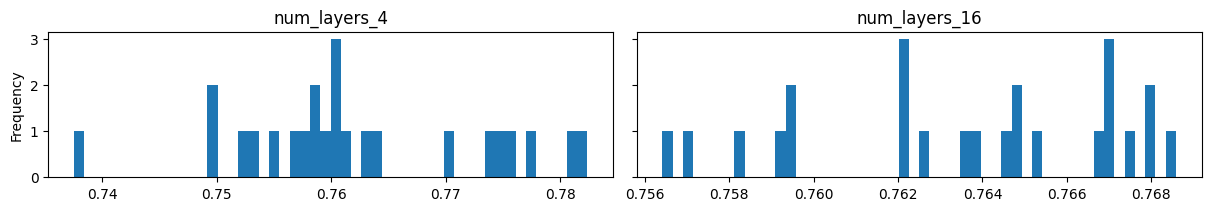

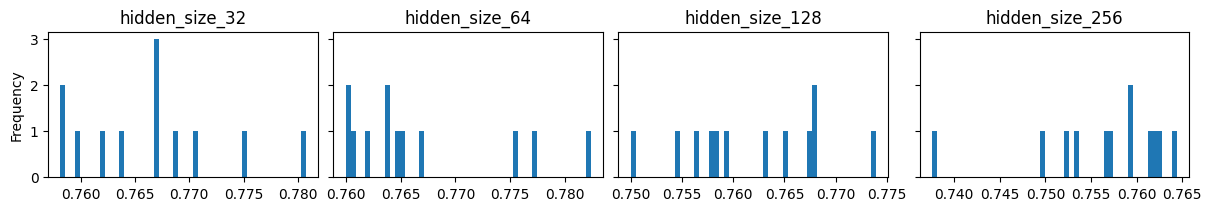

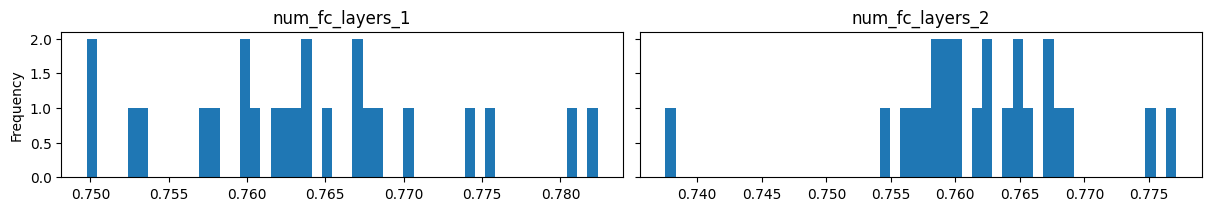

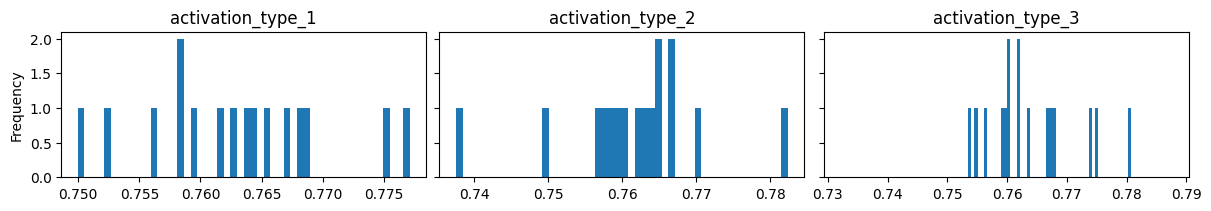

In [24]:
accuracy_desc = sorted_results["mean_accuracy"].astype("float32").describe()
xlimit_range = [
    accuracy_desc["min"] - accuracy_desc["std"],
    accuracy_desc["max"] + accuracy_desc["std"],
]
for hperparameter_name in turning_parameters:
    parameter_group = sorted_results.groupby(hperparameter_name)
    fix, axs = pyplot.subplots(
        1,
        len(parameter_group),
        layout="constrained",
        sharex=False,
        sharey=True,
        figsize=(12, 2),
    )
    for i, g in enumerate(parameter_group):
        g[1]["mean_accuracy"].astype("float32").plot(
            kind="hist", bins=50, subplots=True, sharex=False, sharey=True, ax=axs[i]
        )
        axs[i].set_title(f"{hperparameter_name}_{g[0]}")

pyplot.xlim(xlimit_range)
pyplot.show()

In [25]:
sorted_results_file = f"{log_dir}/sorted_results.csv"
sorted_results = pd.read_csv(sorted_results_file, dtype="str")
best_config = sorted_results.loc[0]
print(best_config)
# id_str_of_best = f"5_5_0.01_{best_config.momentum}_{best_config.optim_type}_{best_config.num_layers}_{best_config.hidden_size}_{best_config.num_fc_layers}_{best_config.activation_type}"
# best_model_name = f"/mnt/AIWorkSpace/work/fin-ml/runs/{_TARGET_STK}/{time_str}/{id_str_of_best}.pt"
# print(best_model_name)

Unnamed: 0                           4
mean_accuracy       0.7823684782608694
trial_id                   d8976_00004
return_period                        5
seq_len                              5
lr                                0.01
momentum           0.11646759543664197
optim_type                           1
num_layers                           4
hidden_size                         64
num_fc_layers                        1
activation_type                      2
Name: 0, dtype: object


In [27]:
import math
from sklearn.metrics import mean_squared_error

pd.set_option("display.precision", 5)

model, config = load_model(f"{log_dir_base}/{task_name}.pt")
model.to(device)

train_loader, test_loader, features_size = prepare_dataloader(config["return_period"])
model.eval()

(trainAccuracy, trainF1) = eval_dl_method(model, train_loader, device=device)
(testAccuracy, testF1) = eval_dl_method(model, test_loader, device=device)
print(f"Train Accuracy: {trainAccuracy:.2f}\nTest Accuracy: {testAccuracy:.5f}")
print(f"Train F1: {trainF1:.2f}\nTest F1: {testF1:.5f}")

Train Accuracy: 0.87
Test Accuracy: 0.76500
Train F1: 0.00
Test F1: 0.00000
